In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt
import glob
import shutil
import logging

import random
from random import shuffle

import imgaug as ia
import imgaug.augmenters as iaa

logger = tf.get_logger()
logger.setLevel(logging.ERROR)


print("Num GPUS avadible:",len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUS avadible: 1


In [2]:

val_dir = os.path.join('val1_2cat' )
test1_dir = os.path.join('test1_2cat')

img_height=299
img_width=299
batch_size=16

In [3]:

val_0 = os.path.join(val_dir, '0') 
val_1 = os.path.join(val_dir, '1')

test_0 = os.path.join(test1_dir, '0') 
test_1 = os.path.join(test1_dir, '1')


#numeros
num_0_vl = len(os.listdir(val_0))
num_1_vl = len(os.listdir(val_1))

num_0_t = len(os.listdir(test_0))
num_1_t = len(os.listdir(test_1))


total_val = num_0_vl + num_1_vl
total_test = num_0_t + num_1_t

In [5]:
def rescale_0_to_1(image):
    """
    Rescale image to [0, 1].
    :param image:
        Required. Image tensor.
    :return:
        Scaled image.
    """
    return tf.image.convert_image_dtype(image, tf.float64)

def rescale_min_1_to_1(image):
    """
    Rescale image to [-1, 1].
    :param image:
        Required. Image tensor.
    :return:
        Scaled image.
    """
    # Image must be casted to float32 first.
    image = tf.cast(image, tf.float64)
    # Rescale image from [0, 255] to [0, 2].
    image = tf.multiply(image, 1. / 127.5)
    # Rescale to [-1, 1].
    return tf.subtract(image, 1.0)

In [7]:
image_gen_val = ImageDataGenerator(
    preprocessing_function=rescale_min_1_to_1
)

val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                   directory=val_dir,
                                                   target_size=(img_height,img_width),
                                                   class_mode='binary'
                                                  )

Found 19999 images belonging to 2 classes.


In [9]:
image_gen_test = ImageDataGenerator(
    preprocessing_function=rescale_min_1_to_1
)

test_data_gen = image_gen_test.flow_from_directory(batch_size=batch_size,
                                                   directory=test1_dir,
                                                   target_size=(img_height,img_width),
                                                   class_mode='binary'
                                                  )

Found 12865 images belonging to 2 classes.


In [11]:
import math  
   
####val####

number_of_examples1 = len(val_data_gen.filenames)
number_of_generator_calls1 = math.ceil(number_of_examples1 / (1.0 * batch_size)) 
# 1.0 above is to skip integer division

val_labels = []

for i in range(0,int(number_of_generator_calls1)):
    val_labels.extend(np.array(val_data_gen[i][1]))
    
    
    
    
####test####
    
number_of_examples2 = len(test_data_gen.filenames)
number_of_generator_calls2 = math.ceil(number_of_examples2 / (1.0 * batch_size)) 
# 1.0 above is to skip integer division

test_labels = []

for i in range(0,int(number_of_generator_calls2)):
    test_labels.extend(np.array(test_data_gen[i][1]))    

In [13]:
model = tf.keras.models.load_model('prueban14.h5')

y_pred1 =  model.predict_generator(val_data_gen, steps= int(np.ceil(total_val / float(batch_size))))

y_pred2 =  model.predict_generator(test_data_gen, steps= int(np.ceil(total_test / float(batch_size))))



In [14]:
from sklearn.metrics import roc_curve,roc_auc_score

fpr1 , tpr1 , thresholds1 = roc_curve ( val_labels , y_pred1)

fpr2 , tpr2 , thresholds2 = roc_curve ( test_labels , y_pred2)



In [15]:
def plot_roc_curve(fpr,tpr): 
  plt.plot(fpr,tpr) 
  plt.axis([0,1,0,1]) 
  plt.xlabel('False Positive Rate') 
  plt.ylabel('True Positive Rate') 
  plt.show()    
  


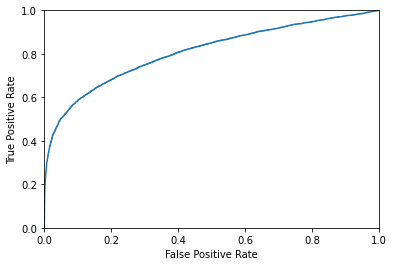

In [16]:
plot_roc_curve (fpr1,tpr1)

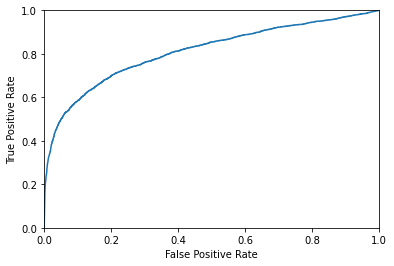

In [17]:
plot_roc_curve (fpr2,tpr2)

In [18]:
def tpr_to_umbrales(tpr,fpr,thresholds,lista):
    umbrales=[]
    fprumb=[]
    
    for i in lista:
        umbrales.append(thresholds[(np.where(tpr>=i))[0][0]])
        fprumb.append(fpr[(np.where(tpr>=i))[0][0]])
    
    return (umbrales, fprumb)

In [19]:
lista=[0.98,0.95,0.90,0.80]
  

umbrales , fprumb =tpr_to_umbrales(tpr1,fpr1,thresholds1,lista)

for idx,i in enumerate(lista):
    print("tpr:"+str(i)+"->fpr: "+str(fprumb[idx])+" con umbral: "+str(umbrales[idx]))

tpr:0.98->fpr: 0.9271368839536637 con umbral: 3.2375994e-36
tpr:0.95->fpr: 0.8097196517924463 con umbral: 1.6602131e-31
tpr:0.9->fpr: 0.6332168071834944 con umbral: 3.8266955e-25
tpr:0.8->fpr: 0.38912879566796904 con umbral: 6.5901383e-15


In [20]:
umbrales , fprumb =tpr_to_umbrales(tpr2,fpr2,thresholds2,lista)

for idx,i in enumerate(lista):
    print("tpr:"+str(i)+"->fpr: "+str(fprumb[idx])+" con umbral: "+str(umbrales[idx]))

tpr:0.98->fpr: 0.9345794392523364 con umbral: 1.5168419e-36
tpr:0.95->fpr: 0.8158143442192587 con umbral: 5.918002e-32
tpr:0.9->fpr: 0.6422345899401449 con umbral: 7.1935215e-26
tpr:0.8->fpr: 0.37215163288879555 con umbral: 1.0570978e-14
